# Desafio Senior Pesquisador 2020

## Descrição

Realizar análise em uma base de dados com mensagens de spam e mensagens comuns. Após isso, criar um modelo de predição, que classifica mensagens em Spam ou Comum.

## Dataset

O arquivo sms-senior.csv contém 4827 mensagens comuns e 747 mensagens spams, com as seguintes colunas:

* Full_Text - Mensagem original;
* got ... wan - 149 colunas com valores inteiros que representam a frequência que a palavra aparece no texto;
* Common_Words_Count - Quantidade total de palavras;
* Date - Data de recebimento da mensagem em formato string;
* IsSpam - Identificador de spam ou não (valores: yes e no)

## Checando o dataset

Vamos verificar o conteúdo do dataset utilizando a biblioteca pandas e utilizar a biblioteca numpy para algumas operações com arrays.

In [2]:
import pandas as pd
import numpy as np

Lendo o dataset em um dataframe

In [3]:
df_sms = pd.read_csv('datasets/sms_senior.csv')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa3 in position 82: invalid start byte

A codificação padrão do pandas resulta em erro para abrir o arquivo csv. Vamos abrir com outra codificação latina (ISO 8859-1)

In [5]:
df_sms = pd.read_csv('datasets/sms_senior.csv',encoding='iso-8859-1')
df_sms.head()

,Full_Text,got,great,wat,free,text,txt,win,already,dun,...,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count,Date,IsSpam
0,Hey! Congrats 2u2. id luv 2 but ive had 2 go h...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,12,2017-01-01 00:08:00,no
1,"came to look at the flat, seems ok, in his 50s...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,23,2017-01-01 00:19:00,no
2,Urgent! call 09061749602 from Landline. Your c...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,25,2017-01-01 01:53:00,yes
3,Do you hide anythiing or keeping distance from me,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,2017-01-01 02:14:00,no
4,"Actually, my mobile is full of msg. And i m do...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,29,2017-01-01 02:25:00,no


In [7]:
df_sms.columns

Index(['Full_Text', 'got', 'great', 'wat', 'free', 'text', 'txt', 'win',
       'already', 'dun',
       ...
       'number', 'wish', 'leave', 'thing', 'many', 'wan', 'Common_Word_Count',
       'Word_Count', 'Date', 'IsSpam'],
      dtype='object', length=154)

Como são muitas colunas que representam as frequências das palavras, vamos criar um dataframe sem essas colunas e armazenar essas palavras em um array.

In [8]:
df_sms_no_cw = df_sms[['Full_Text', 'Common_Word_Count', 'Word_Count', 'Date', 'IsSpam']]
common_words = df_sms.drop(['Full_Text','Common_Word_Count','Word_Count','Date','IsSpam'], axis=1).columns

In [9]:
df_sms_no_cw.head()

,Full_Text,Common_Word_Count,Word_Count,Date,IsSpam
0,Hey! Congrats 2u2. id luv 2 but ive had 2 go h...,3,12,2017-01-01 00:08:00,no
1,"came to look at the flat, seems ok, in his 50s...",3,23,2017-01-01 00:19:00,no
2,Urgent! call 09061749602 from Landline. Your c...,4,25,2017-01-01 01:53:00,yes
3,Do you hide anythiing or keeping distance from me,0,9,2017-01-01 02:14:00,no
4,"Actually, my mobile is full of msg. And i m do...",9,29,2017-01-01 02:25:00,no


In [12]:
print("Tamanho da lista de palavras {}\n".format(len(common_words)))
print(common_words)

Tamanho da lista de palavras 149

Index(['got', 'great', 'wat', 'free', 'text', 'txt', 'win', 'already', 'dun',
       'say',
       ...
       'sleep', 'care', 'mins', 'phone', 'number', 'wish', 'leave', 'thing',
       'many', 'wan'],
      dtype='object', length=149)


## Análise Exploratória de Dados

Criar um dataframe com as frequências das palavras e plotar a soma das frequências de cada coluna.

Mas antes disso, vamos verificar se a lista de palavras não contém palavras vazias, ou seja, palavras mais comuns do idioma, como pronomes, artigos, preposições e palavras de ligação.

Para isso, utilizaremos a biblioteca nltk para baixar e importar as palavras vazias (stopwords) do idioma inglês

In [13]:
import nltk
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> l

Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [ ] cess_esp............ CESS-ESP Treebank
  [ ] chat80.....

      Package stopwords is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [18]:
from nltk.corpus import stopwords
print("Tamanho da lista de palavras vazias {}".format(len(stopwords.words('english'))))
print(stopwords.words('english'))

Tamanho da lista de palavras vazias 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not'

Remover as possíveis palavras vazias que possam existir na lista.

In [19]:
common_words = [word for word in common_words if word not in stopwords.words('english')]
len(common_words)

144

5 palavras foram removidas da lista.

Agora criaremos um dataframe com as frequências das palavras.

In [20]:
df_cw = df_sms[common_words]
df_cw.head()

,got,great,wat,free,text,txt,win,already,dun,say,...,sleep,care,mins,phone,number,wish,leave,thing,many,wan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1. Exibir gŕafico das palavras mais frequentes

Vamos plotar um gráfico de barras com a soma das frequências, utilizando as bibliotecas matplotlib e seaborn.

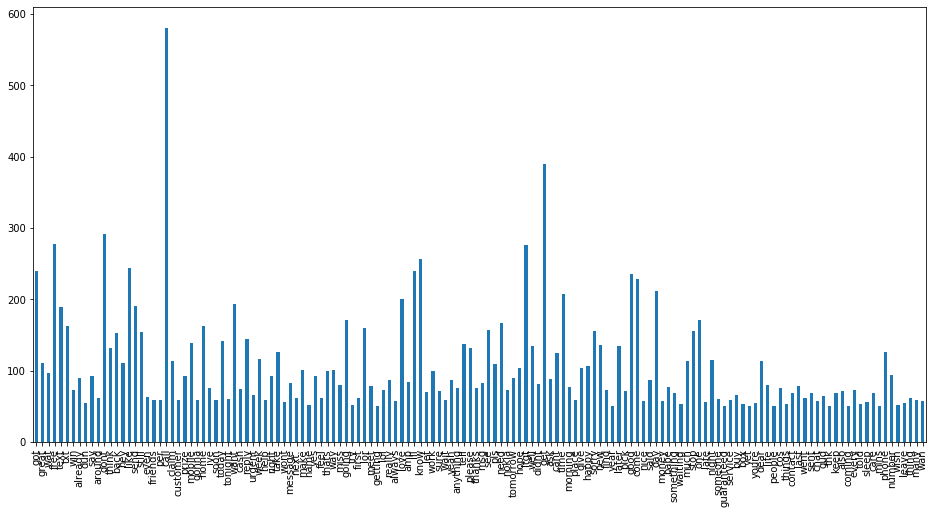

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
df_cw.sum().plot.bar(figsize=(16,8))

Como são muitas palavras, dividiremos o DataFrame em três e verificaremos as palavras mais frequentes.

In [24]:
df_cw_1, df_cw_2, df_cw_3 = df_cw.iloc[:,:50], df_cw.iloc[:,50:100], df_cw.iloc[:,100:144]

## Plot das primeiras 50

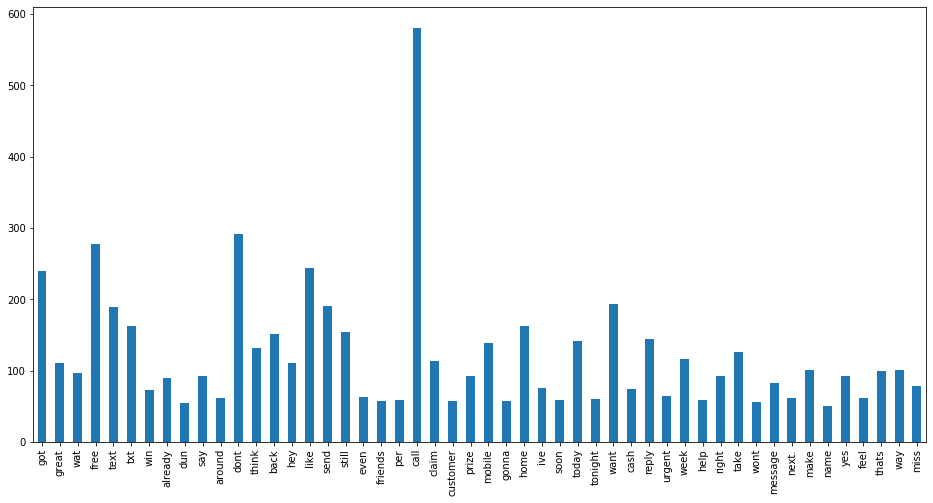

In [25]:
df_cw_1.sum().plot.bar(figsize=(16,8))

## Plot das próximas 50

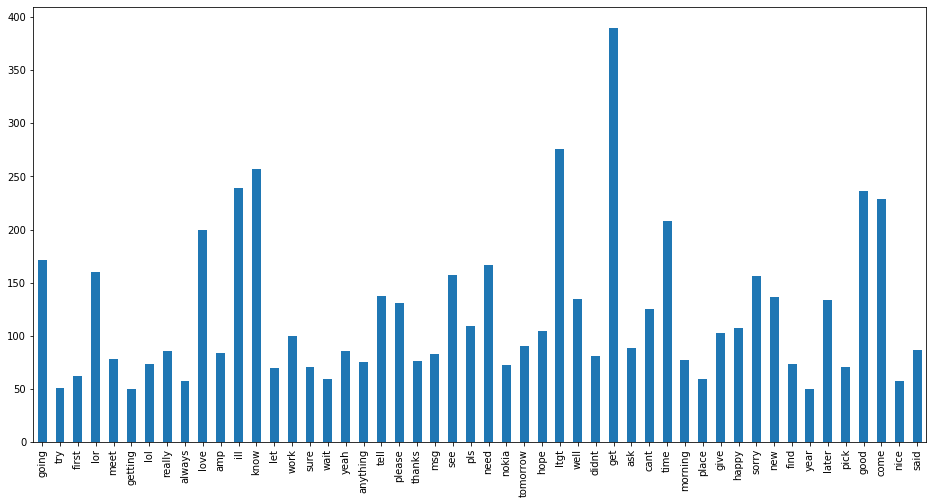

In [27]:
df_cw_2.sum().plot.bar(figsize=(16,8))

## Plot das últimas 44 palavras

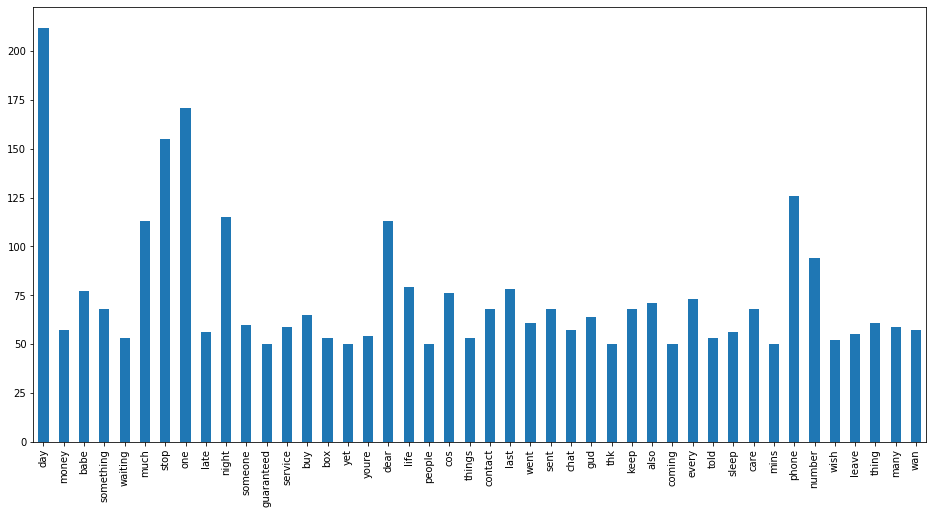

In [28]:
df_cw_3.sum().plot.bar(figsize=(16,8))

## Plot das 100 palavras mais frequentes

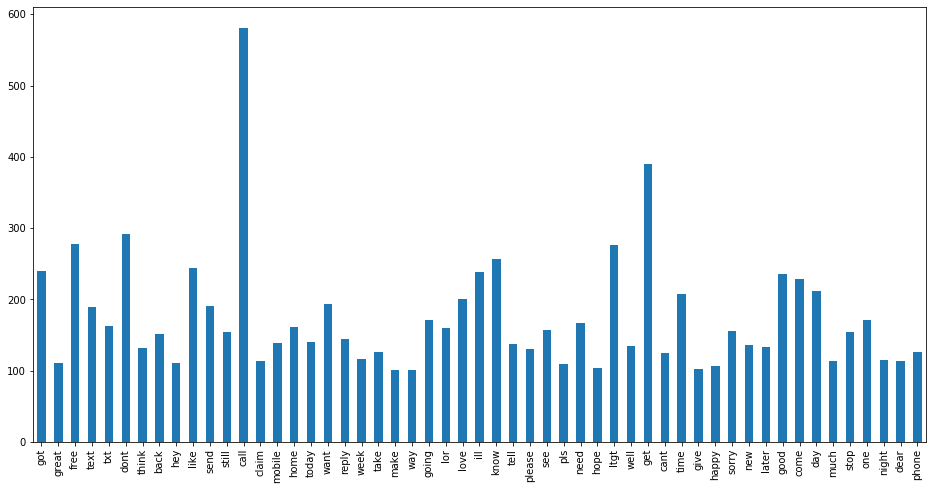

In [29]:
df_cw_100 = df_cw.loc[:,df_cw.sum().values > 100]
df_cw_100.sum().plot.bar(figsize=(16,8))

Existe uma palavra que chama-se "ltgt" no dataset. Essa palavra é um erro de decodifação dos caracteres "<" e ">". Vamos retirá-la, pois ela não tem impacto.

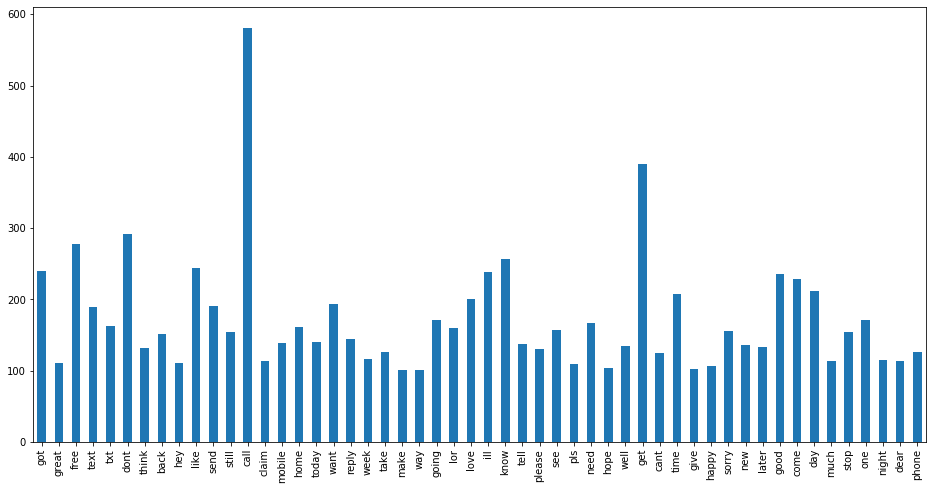

In [30]:
common_words.remove('ltgt')
df_cw_100 = df_cw_100.drop('ltgt', axis=1)
df_cw_100.sum().plot.bar(figsize=(16,8))

## Nuvem das palavras mais frequentes

Vamos utilizar a biblioteca WordCloud para gerar a nuvem e a biblioteca Pillow para carregar uma imagem para ser a máscara.

In [31]:
from wordcloud import WordCloud
from PIL import Image

Criaremos um dicionário com a soma das frequências para gerar a nuvem de palavras. Já definiremos o fundo da nuvem para ser branco.

In [32]:
dict_cw = df_cw_100.sum().to_dict()
wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(frequencies=dict_cw)

Abrindo a imagem para ser a máscara

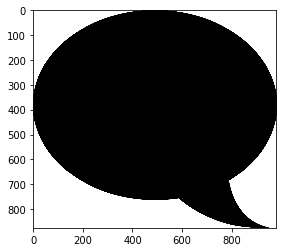

In [33]:
image = Image.open('res/message-icon.png')
%matplotlib inline
plt.imshow(image)

Transformaremos a imagem em um numpy array

In [34]:
mask = np.array(image)
mask

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       ...,

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255

Adicionaremos essa máscara à nuvem de palavras e plotamos a nuvem.

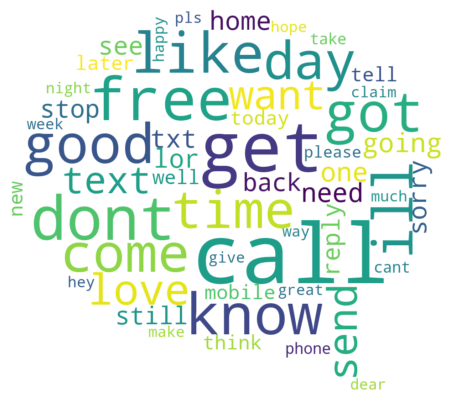

In [37]:
wordcloud = WordCloud(background_color='white', mask=mask)
wordcloud.generate_from_frequencies(frequencies=dict_cw)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 2. Gráfico com as quantidades de mensagens comuns e spams por mês

Checando qual a faixa de meses do dataset

In [38]:
print("De {}".format(df_sms_no_cw['Date'].min()))
print("... até {}".format(df_sms_no_cw['Date'].max()))

De 2017-01-01 00:08:00
... até 2017-03-31 23:56:00


A data está em formato String. Vamos transformá-la em datetime e extrair os meses e dias para outras colunas.

In [39]:
import datetime
df_sms_no_cw['Date'] = pd.to_datetime(df_sms_no_cw['Date'])
df_sms_no_cw['Day'] = df_sms_no_cw['Date'].dt.strftime('%d')
df_sms_no_cw['Month'] = df_sms_no_cw['Date'].dt.strftime('%m')
df_sms_no_cw.head()

/home/mateusbueno/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mateusbueno/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mateusbueno/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,Full_Text,Common_Word_Count,Word_Count,Date,IsSpam,Day,Month
0,Hey! Congrats 2u2. id luv 2 but ive had 2 go h...,3,12,2017-01-01 00:08:00,no,01,01
1,"came to look at the flat, seems ok, in his 50s...",3,23,2017-01-01 00:19:00,no,01,01
2,Urgent! call 09061749602 from Landline. Your c...,4,25,2017-01-01 01:53:00,yes,01,01
3,Do you hide anythiing or keeping distance from me,0,9,2017-01-01 02:14:00,no,01,01
4,"Actually, my mobile is full of msg. And i m do...",9,29,2017-01-01 02:25:00,no,01,01


Plotaremos o gráfico em barras da comparação entre a quantidade de mensagens comuns e spam por mês.

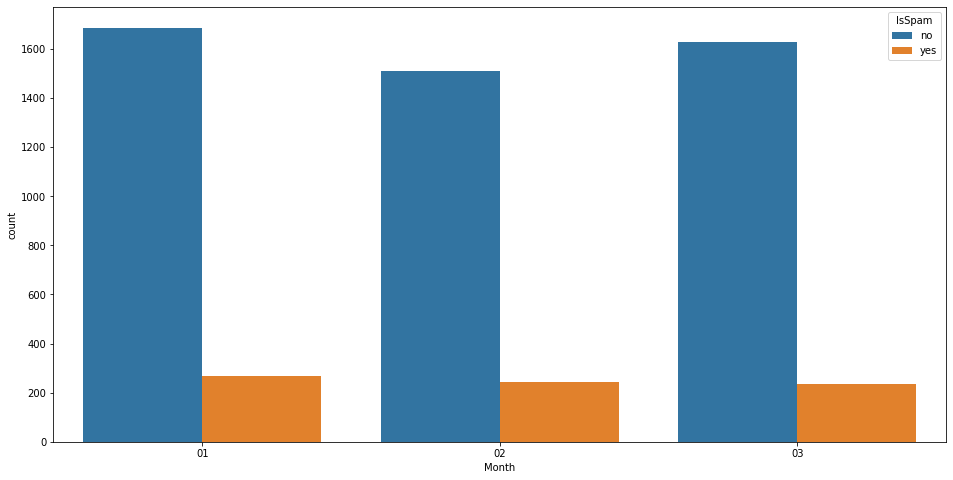

In [40]:
plt.figure(figsize=(16,8))
sns.countplot(data=df_sms_no_cw, x='Month', hue='IsSpam')

## 3. Calcular o máximo, o mínimo, a média, a mediana, o desvio padrão e a variância da quantidade total de palavras por mês

In [42]:
print("Máximo\n")
print(df_sms_no_cw.groupby('Month').max()['Word_Count'])

Máximo

Month
01    190
02    100
03    115
Name: Word_Count, dtype: int64


In [43]:
print("Mínimo\n")
print(df_sms_no_cw.groupby('Month').min()['Word_Count'])

Mínimo

Month
01    2
02    2
03    2
Name: Word_Count, dtype: int64


In [44]:
print("Média\n")
print(df_sms_no_cw.groupby('Month').mean()['Word_Count'])

Média

Month
01    16.336918
02    16.029043
03    16.285255
Name: Word_Count, dtype: float64


In [45]:
print("Mediana\n")
print(df_sms_no_cw.groupby('Month').median()['Word_Count'])

Mediana

Month
01    13
02    13
03    12
Name: Word_Count, dtype: int64


In [46]:
print("Desvio Padrão\n")
print(df_sms_no_cw.groupby('Month').std()['Word_Count'])

Desvio Padrão

Month
01    12.557171
02    11.042459
03    11.576213
Name: Word_Count, dtype: float64


In [47]:
print("Variância\n")
print(df_sms_no_cw.groupby('Month').var()['Word_Count'])

Variância

Month
01    157.682535
02    121.935908
03    134.008715
Name: Word_Count, dtype: float64


## 4. Exibir o dia de cada mês que possui a maior sequência de mensagens comuns

Primeiramente, vamos criar dataframes para cada mês (janeiro, fevereiro e março), e selecionaremos apenas as colunas 'Day' e 'IsSpam'.

In [48]:
df_sms_jan = df_sms_no_cw[df_sms_no_cw['Month']=='01']
df_sms_feb = df_sms_no_cw[df_sms_no_cw['Month']=='02']
df_sms_mar = df_sms_no_cw[df_sms_no_cw['Month']=='03']
df_sms_jan = df_sms_jan[['Day','IsSpam']]
df_sms_feb = df_sms_feb[['Day','IsSpam']]

df_sms_mar = df_sms_mar[['Day','IsSpam']]

In [49]:
df_sms_jan.head()

,Day,IsSpam
0,01,no
1,01,no
2,01,yes
3,01,no
4,01,no


In [50]:
df_sms_feb.head()

,Day,IsSpam
1953,01,no
1954,01,no
1955,01,no
1956,01,no
1957,01,no


In [51]:
df_sms_mar.head()

,Day,IsSpam
3709,01,no
3710,01,no
3711,01,no
3712,01,yes
3713,01,no


Vamos criar um dataframe de janeiro com a contagem de sequências de 'no' e 'yes' para a coluna 'IsSpam'

In [63]:
df1 = (df_sms_jan.groupby([df_sms_jan['Day'], df_sms_jan['IsSpam'].rename('spam'), df_sms_jan['IsSpam'].ne(df_sms_jan['IsSpam'].shift()).cumsum().rename('Counts')]).size().to_frame(name='longest_sequence'))
df1.head(20)

longest_sequence
Day spam Counts                  
01  no   1                      2
         3                      4
         5                      6
         7                      3
         9                     19
         11                    22
         13                     8
         15                     4
         17                     1
    yes  2                      1
         4                      1
         6                      1
         8                      1
         10                     1
         12                     1
         14                     1
         16                     1
02  no   17                     4
         19                    11
         21                     1

Agora selecionaremos apenas as contagens máximas para 'no' em 'IsSpam'

In [64]:
df1 = df1.query('spam=="no"').max(level=0).reindex(df_sms_jan['Day'].unique(), fill_value=0).reset_index()
df1

,Day,longest_sequence
0,01,22
1,02,21
2,03,18
3,04,14
4,05,11
5,06,15
6,07,14
7,08,27
8,09,19
9,10,15


Por fim selecionaremos o índice com o maior sequência para obter o dia.

In [65]:
i = df1['longest_sequence'].idxmax()
df1['Day'].iloc[i]

'26'

Fazendo o mesmo para os outros meses.

In [67]:
df2 = (df_sms_feb.groupby([df_sms_feb['Day'], df_sms_feb['IsSpam'].rename('spam'), df_sms_feb['IsSpam'].ne(df_sms_feb['IsSpam'].shift()).cumsum()]).size().to_frame(name='longest_sequence'))
df2 = df2.query('spam=="no"').max(level=0).reindex(df_sms_feb['Day'].unique(), fill_value=0).reset_index()
j = df2['longest_sequence'].idxmax()

df3 = (df_sms_mar.groupby([df_sms_mar['Day'], df_sms_mar['IsSpam'].rename('spam'), df_sms_mar['IsSpam'].ne(df_sms_mar['IsSpam'].shift()).cumsum()]).size().to_frame(name='longest_sequence'))
df3 = df3.query('spam=="no"').max(level=0).reindex(df_sms_mar['Day'].unique(), fill_value=0).reset_index()
k = df3['longest_sequence'].idxmax()

In [68]:
print("Dia em janeiro com a maior sequência de mensagens comuns: {}".format(df1['Day'].iloc[i]))
print("Dia em fevereiro com a maior sequência de mensagens comuns: {}".format(df2['Day'].iloc[j]))
print("Dia em março com a maior sequência de mensagens comuns: {}".format(df3['Day'].iloc[k]))

Dia em janeiro com a maior sequência de mensagens comuns: 26
Dia em fevereiro com a maior sequência de mensagens comuns: 04
Dia em março com a maior sequência de mensagens comuns: 31


# Segunda Etapa

Classificação de mensagens comuns e spam.

Primeiro removeremos as stopwords do nosso DataFrame principal, utilizando nossa lista de palavras já pré-processada.

In [69]:
common_words.insert(0,'Full_Text')
common_words.append('Common_Word_Count')
common_words.append('Word_Count')
common_words.append('Date')
common_words.append('IsSpam')
df_sms = df_sms[common_words]
df_sms.head()

,Full_Text,got,great,wat,free,text,txt,win,already,dun,...,number,wish,leave,thing,many,wan,Common_Word_Count,Word_Count,Date,IsSpam
0,Hey! Congrats 2u2. id luv 2 but ive had 2 go h...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,12,2017-01-01 00:08:00,no
1,"came to look at the flat, seems ok, in his 50s...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,23,2017-01-01 00:19:00,no
2,Urgent! call 09061749602 from Landline. Your c...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,25,2017-01-01 01:53:00,yes
3,Do you hide anythiing or keeping distance from me,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,2017-01-01 02:14:00,no
4,"Actually, my mobile is full of msg. And i m do...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,29,2017-01-01 02:25:00,no


## Frequência de Termos

Criaremos um array com as frequências das palavras e transformaremos em uma matriz esparsa denominada Bag of Words (bows).

In [70]:
bows = df_sms.iloc[:,1:144].to_numpy()
bows

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [72]:
from scipy import sparse
bows = sparse.csr_matrix(bows)
bows.shape

(5574, 143)

## Frequência do Termo - Inverso da Frequência nos Documentos

Criaremos uma matriz com as importâncias dos termos nos textos em relação a todo o conjunto de textos.

In [78]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer().fit(bows)
sms_tfidf = tfidf.transform(bows)
sms_tfidf.shape

(5574, 143)

## Separação entre base de treinos e de testes

Utilizaremos a biblioteca sklearn para selecionar, treinar e testar nosso modelo preditivo.
Primeiro, vamos separar nossa base de treino e de testes, deixando 30% para testes, utilizando o número 42 como semente para a função aleatória, a qual determinará os valores para as bases de treino e testes.

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sms_tfidf,df_sms['IsSpam'],test_size=0.3,random_state=42)

## Criando o modelo

Utilizaremos um classificador Multinomial Naive-Bayes para criar o modelo preditivo.

In [80]:
from sklearn.naive_bayes import MultinomialNB
multinomialnb_model = MultinomialNB().fit(X_train, y_train)

## Validação

Criaremos as predições e comparamos com o conjunto de testes utilizando o relatório de classificação do sklearn.

In [82]:
predictions = multinomialnb_model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          no       0.95      0.99      0.97      1456
         yes       0.90      0.68      0.77       217

    accuracy                           0.95      1673
   macro avg       0.93      0.84      0.87      1673
weighted avg       0.95      0.95      0.95      1673



Conseguimos acurácia de 95% utilizano Naive-Bayes, vamos tentar com outros modelos de Machine Learning.

## Random Forest Classifier

Vamos utilizar um classificador de floresta aleatória com 100 estimators.

In [83]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,max_depth=None,n_jobs=-1)
rfc_model = rfc.fit(X_train,y_train)
rfc_pred = rfc_model.predict(X_test)
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

          no       0.97      0.99      0.98      1456
         yes       0.90      0.77      0.83       217

    accuracy                           0.96      1673
   macro avg       0.94      0.88      0.91      1673
weighted avg       0.96      0.96      0.96      1673



Aumentamos a precisão para mensagens comuns e aumentamos 1% a acurácia. Vamos ver outro modelo.

## Support Vector Machine Classifier

Vamos utilizar um classificador SVM com um otimizador C com valor 1000 para diminuir bastante a margem de erro na classificação.

In [86]:
from sklearn import svm
svm_c = svm.SVC(C=1000)
svm_model = svm_c.fit(X_train,y_train)
svm_pred = svm_model.predict(X_test)
print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

          no       0.97      0.99      0.98      1456
         yes       0.90      0.79      0.84       217

    accuracy                           0.96      1673
   macro avg       0.94      0.89      0.91      1673
weighted avg       0.96      0.96      0.96      1673



Aumentamos o reccal e o f1-score para as mensagens Spam nesse modelo.

## Outra abordagem - Extraindo diretamente dos textos

Utilizaremos outra abordagem agora, para efeitos de comparação, onde extrairemos os termos diretamente das mensagens, calculando o TF e o TF-IDF diretamente dos documentos. Vamos aplicar os mesmos modelos de Machine Learning que aplicamos acima.

Vamos selecionar apenas as colunas 'Full_Text' e 'IsSpam'

In [87]:
df_spam = df_sms[['Full_Text','IsSpam']]
df_spam.head()

,Full_Text,IsSpam
0,Hey! Congrats 2u2. id luv 2 but ive had 2 go h...,no
1,"came to look at the flat, seems ok, in his 50s...",no
2,Urgent! call 09061749602 from Landline. Your c...,yes
3,Do you hide anythiing or keeping distance from me,no
4,"Actually, my mobile is full of msg. And i m do...",no


Criaremos uma função para remover pontuação e palavras vazias. Essa função retornará um array com os termos extraídos que servirá para calcular as frequências.

In [91]:
import string
def term_extract(text):
    remove_punc = [char for char in text if char not in string.punctuation]
    remove_punc = ''.join(remove_punc) # transforma em string
    return [word for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

Vamos criar um pipeline com a sequência de processamento para criação do modelo. A primeira etapa é criar a Bag of Words utilizando a função CountVectorizer da biblioteca Sklearn. Depois, calcula-se o TfIdf dos termos e, por fim, utilizamos o modelo de classificação.

## Utilizando Naive-Bayes

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=term_extract)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

Selecionando a base de treinos e testes e treinando o modelo.

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df_spam['Full_Text'], df_spam['IsSpam'], test_size=0.3, random_state=42)
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function term_extract at 0x7f893e72dd40>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

Gerando as predições e validando com a base de testes

In [94]:
predictions = pipeline.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          no       0.95      1.00      0.98      1456
         yes       1.00      0.67      0.80       217

    accuracy                           0.96      1673
   macro avg       0.98      0.84      0.89      1673
weighted avg       0.96      0.96      0.95      1673



Aumentamos a precisão de classificação de spams em 100%. A acurácia ainda é 96%.

## Utilizando Random Forest

In [95]:
pipeline_rfc = Pipeline([
    ('bow', CountVectorizer(analyzer=term_extract)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(n_estimators=100,max_depth=None,n_jobs=-1))
])
pipeline_rfc.fit(X_train,y_train)
predictions_rfc = pipeline_rfc.predict(X_test)
print(classification_report(y_test,predictions_rfc))

              precision    recall  f1-score   support

          no       0.96      1.00      0.98      1456
         yes       0.98      0.75      0.85       217

    accuracy                           0.97      1673
   macro avg       0.97      0.87      0.92      1673
weighted avg       0.97      0.97      0.96      1673



Aumentamos a acurácia para 97% e a precisão para mensagens comuns foi para 96%. A precisão para Spams desceu para 98%

## Utilizando SVM

In [96]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=term_extract)),
    ('tfidf', TfidfTransformer()),
    ('classifier', svm.SVC(C=1000))
])
pipeline_svm.fit(X_train,y_train)
predictions_svm = pipeline_svm.predict(X_test)
print(classification_report(y_test,predictions_svm))

              precision    recall  f1-score   support

          no       0.97      1.00      0.99      1456
         yes       1.00      0.82      0.90       217

    accuracy                           0.98      1673
   macro avg       0.99      0.91      0.94      1673
weighted avg       0.98      0.98      0.98      1673



Novamente, precisão de classificação de spams em 100%. A precisão de mensagens comuns também está alta, em 97%. A acurácia bateu 98%.

Este foi o melhor modelo criado nessa análise. Para passos futuros, recomenda-se o teste com mais otimizadores para o SVM, talvez utilizando um GridSearch para identificar os melhores parâmetros.